## Load parquet

In [1]:
%matplotlib widget
%matplotlib inline

In [2]:

import pandas as pd

import matplotlib.pyplot as plt
import pandas_ta as ta

In [3]:
df = pd.read_parquet("data.parquet")

In [4]:
df.head()

,name,id,figi,ts,open_price,close_price,high_price,low_price,volume
0,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:45:00+00:00,114.02,114.02,114.02,114.02,6.0
1,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:35:00+00:00,114.02,114.02,114.02,114.02,10.0
2,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:55:00+00:00,114.20,114.23,114.26,114.16,76837.0
3,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:50:00+00:00,114.37,114.21,114.39,114.19,34299.0
4,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:45:00+00:00,114.33,114.36,114.41,114.31,27240.0


In [5]:
df.groupby("name").count()

,id,figi,ts,open_price,close_price,high_price,low_price,volume
name,,,,,,,,
AT&T,101134,101134,101134,101134,101134,101134,101134,101134
Apple,119367,119367,119367,119367,119367,119367,119367,119367
JPMorgan,85536,85536,85536,85536,85536,85536,85536,85536


## Analyze single stock

### Create dataset with sliding averages

In [31]:
sliding_window_df = df[df["id"] == 1].reset_index()

In [32]:
sliding_window_df.head()

,index,name,id,figi,ts,open_price,close_price,high_price,low_price,volume
0,0,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:45:00+00:00,114.02,114.02,114.02,114.02,6.0
1,1,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:35:00+00:00,114.02,114.02,114.02,114.02,10.0
2,2,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:55:00+00:00,114.20,114.23,114.26,114.16,76837.0
3,3,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:50:00+00:00,114.37,114.21,114.39,114.19,34299.0
4,4,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:45:00+00:00,114.33,114.36,114.41,114.31,27240.0


In [33]:

# List of all indicators
sliding_window_df.ta.indicators()


Pandas TA - Technical Analysis Indicators - v0.2.23b0
Total Indicators: 123
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_doji, cdl_inside, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, decay, decreasing, dema, donchian, dpo, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, ichimoku, increasing, inertia, kama, kc, kdj, kst, kurtosis, linreg, log_return, long_run, macd, mad, massi, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvt, pwma, qstick, quantile, rma, roc, rsi, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, stdev, stoch, stochrsi, supertrend, swma, t3, tema, thermo, trend_return, trima, trix, true_range, tsi, ttm_trend, ui, uo, variance, vortex, vp, vwap, vwma, wcp, willr, wma, zlma, zscore


In [38]:
def preprocess_data(df):
    # Add MACD
    df.ta.macd(append=True)

    # Add RSI
    df.ta.rsi(14, append=True)

    RSI_oversold_threshold = 30
    RSI_overbouht_threshold = 70

    df["RSI_oversold"] = df["RSI_14"] <= RSI_oversold_threshold
    df["RSI_overbought"] = df["RSI_14"] >= RSI_overbouht_threshold

    df["MACD_diff"] = df["MACD_12_26_9"].diff()
    df["MACD_diff"] = df["MACD_12_26_9"].diff()
    df["MACD_crossover"] = (df["MACD_diff"] > 0) & (df["MACD_diff"].shift() < 0)
    df["MACD_crossunder"] = (df["MACD_diff"] < 0) & (df["MACD_diff"].shift() > 0)

    return df

In [34]:
sliding_window_df = preprocess_data(sliding_window_df)
sliding_window_df.head()

,index,name,id,figi,ts,open_price,close_price,high_price,low_price,volume,...,MACDs_12_26_9,RSI_14,MFI_14,RSI_oversold,RSI_overbought,MFI_oversold,MFI_overbought,MACD_diff,MACD_crossover,MACD_crossunder
0,0,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:45:00+00:00,114.02,114.02,114.02,114.02,6.0,...,NaN,NaN,NaN,False,False,False,False,NaN,False,False
1,1,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:35:00+00:00,114.02,114.02,114.02,114.02,10.0,...,NaN,NaN,NaN,False,False,False,False,NaN,False,False
2,2,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:55:00+00:00,114.20,114.23,114.26,114.16,76837.0,...,NaN,100.000000,NaN,False,True,False,False,NaN,False,False
3,3,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:50:00+00:00,114.37,114.21,114.39,114.19,34299.0,...,NaN,90.697674,NaN,False,True,False,False,NaN,False,False
4,4,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:45:00+00:00,114.33,114.36,114.41,114.31,27240.0,...,NaN,94.688458,NaN,False,True,False,False,NaN,False,False


Show MACD RSI

In [35]:
def color_zone(ax, points, alpha, color):
    start_point = 0
    end_point = 0
    for x in points:
        if start_point == 0:
            start_point = x
            end_point = x + 1
        else:
            if end_point == x:
                # Continue
                end_point += 1
            else:
                # Draw and reset
                ax.axvspan(start_point, end_point, alpha=alpha, color=color)
                start_point = 0
                end_point = 0

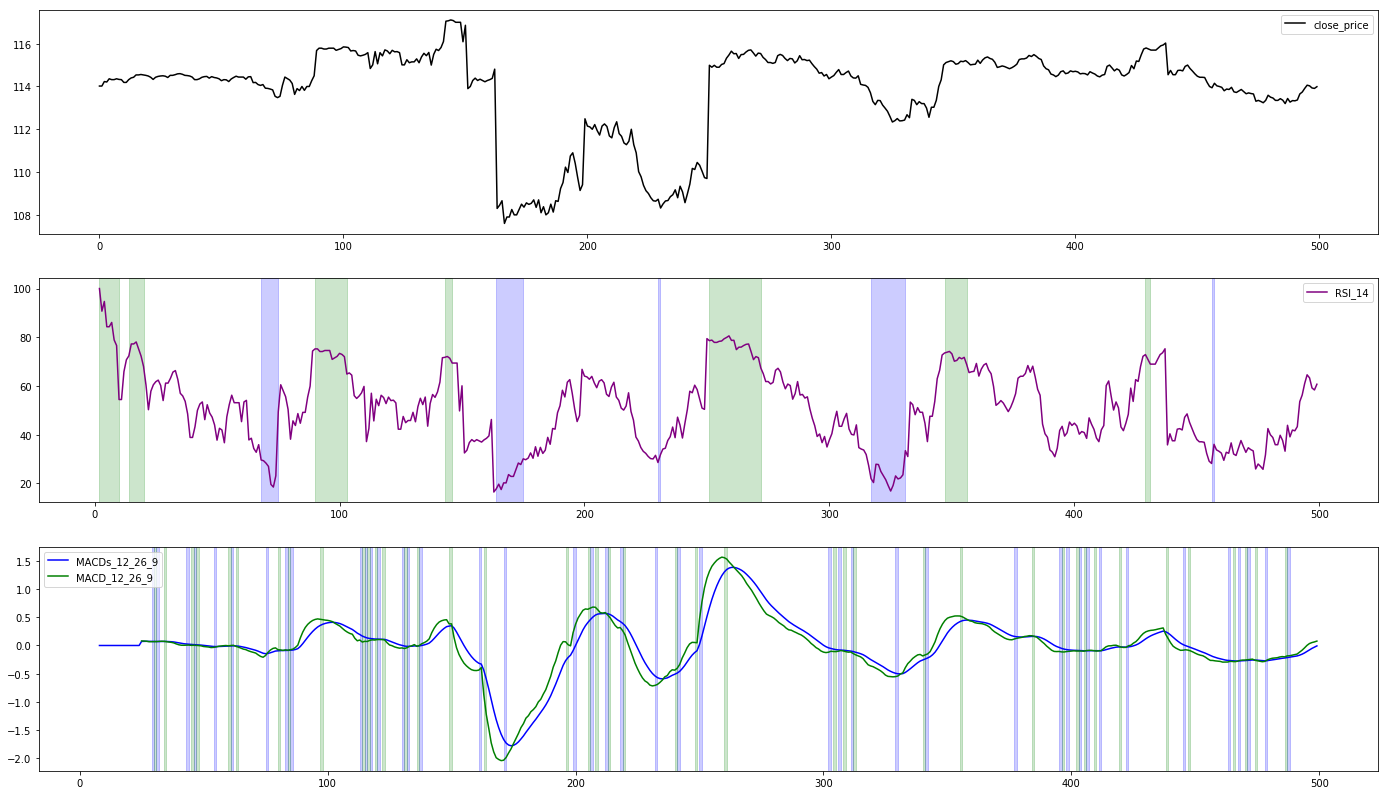

In [37]:
plot_df = sliding_window_df.iloc[0:500]

plt.figure(figsize=(24,14))
plt.subplot(3, 1, 1)
plot_df["close_price"].plot(color="black")
plt.legend()

plt.subplot(3, 1, 2)
ax1 = plot_df["RSI_14"].plot(color="purple")
# Show oversold zone
color_zone(ax1, plot_df[plot_df["RSI_oversold"]].index, 0.2, "blue")
# Show overbought zone
color_zone(ax1, plot_df[plot_df["RSI_overbought"]].index, 0.2, "green")
plt.legend()

plt.subplot(3, 1, 3)
# plot_df["MACDh_12_26_9"].plot(color="red",kind="bar")
plot_df["MACDs_12_26_9"].plot(color="blue")
ax3 = plot_df["MACD_12_26_9"].plot(color="green")
# Show crossover moments
for x in plot_df[plot_df["MACD_crossover"]].index:
    ax3.axvspan(x, x+1, alpha=0.2, color="blue")      
# Show crossunder moments
for x in plot_df[plot_df["MACD_crossunder"]].index:
    ax3.axvspan(x, x+1, alpha=0.2, color="green")
plt.legend()

# Create manual bot

In [20]:
# Create dataset for bot
bot_df = sliding_window_df[["open_price","close_price","high_price","low_price","volume","MACD_12_26_9","RSI_14"]]
bot_df = bot_df.rename(columns={"MACD_12_26_9":"MACD","RSI_14":"RSI"})
bot_df.head()

,open_price,close_price,high_price,low_price,volume,MACD,RSI
0,114.02,114.02,114.02,114.02,6.0,NaN,NaN
1,114.02,114.02,114.02,114.02,10.0,NaN,NaN
2,114.20,114.23,114.26,114.16,76837.0,NaN,100.000000
3,114.37,114.21,114.39,114.19,34299.0,NaN,90.697674
4,114.33,114.36,114.41,114.31,27240.0,NaN,94.688458


In [26]:
from bot import TradingBot

# Test bot
bot = TradingBot(stop_loss=0.1)

bot.reset()

for index, data in bot_df.iterrows():
    bot.process(data)

8
Step: 40687 Sell with price=135.352815 and profit 2.17%
Overall Profit 190.72%
Step: 40779 Buy with price=133.400000
Step: 40849 Sell with price=135.201122 and profit 1.35%
Overall Profit 192.07%
Step: 41215 Buy with price=134.300000
Step: 41233 Sell with price=136.761656 and profit 1.83%
Overall Profit 193.90%
Step: 41284 Buy with price=136.640310
Step: 41300 Sell with price=138.224818 and profit 1.16%
Overall Profit 195.06%
Step: 41445 Buy with price=137.779991
Step: 41742 Sell with price=137.786088 and profit 0.00%
Overall Profit 195.06%
Step: 41790 Buy with price=137.395565
Step: 41818 Sell with price=138.124892 and profit 0.53%
Overall Profit 195.59%
Step: 42151 Buy with price=138.117064
Step: 42274 Sell with price=139.234411 and profit 0.81%
Overall Profit 196.40%
Step: 42375 Buy with price=138.945120
Step: 42520 Sell with price=139.010000 and profit 0.05%
Overall Profit 196.45%
Step: 42603 Buy with price=139.569825
Step: 42638 Sell with price=140.427991 and profit 0.61%
Overal

# Test bot on different stocks

In [40]:
# Select stock #2
bot_df = df[df["id"] == 2].reset_index()
# Preprocess data
bot_df = preprocess_data(bot_df)
# Select columns
bot_df = bot_df[["open_price","close_price","high_price","low_price","volume","MACD_12_26_9","RSI_14"]]
# Rename columns
bot_df = bot_df.rename(columns={"MACD_12_26_9":"MACD","RSI_14":"RSI"})
# Reset bot
bot.reset()
# Run bot
for index, data in bot_df.iterrows():
    bot.process(data)

9%
Overall Profit 348.19%
Step: 78819 Buy with price=73.199401
Step: 79072 Sell with price=72.666503 and profit -0.73%
Overall Profit 347.46%
Step: 79083 Buy with price=72.004318
Step: 79192 Stop loss from 72.00 to 64.65 with profit -10.22%
Step: 79192 Sell with price=64.648800 and profit -10.22%
Overall Profit 337.24%
Step: 79194 Buy with price=65.118863
Step: 79299 Sell with price=74.374345 and profit 14.21%
Overall Profit 351.46%
Step: 79380 Buy with price=70.157593
Step: 79461 Sell with price=72.222318 and profit 2.94%
Overall Profit 354.40%
Step: 79704 Buy with price=74.819930
Step: 79933 Sell with price=74.696282 and profit -0.17%
Overall Profit 354.24%
Step: 80054 Buy with price=72.068217
Step: 80212 Sell with price=72.143258 and profit 0.10%
Overall Profit 354.34%
Step: 80244 Buy with price=66.160676
Step: 80442 Sell with price=71.083052 and profit 7.44%
Overall Profit 361.78%
Step: 80477 Buy with price=68.691003
Step: 80527 Sell with price=69.879996 and profit 1.73%
Overall Pr

In [41]:
# Select stock #2
bot_df = df[df["id"] == 3].reset_index()
# Preprocess data
bot_df = preprocess_data(bot_df)
# Select columns
bot_df = bot_df[["open_price","close_price","high_price","low_price","volume","MACD_12_26_9","RSI_14"]]
# Rename columns
bot_df = bot_df.rename(columns={"MACD_12_26_9":"MACD","RSI_14":"RSI"})
# Reset bot
bot.reset()
# Run bot
for index, data in bot_df.iterrows():
    bot.process(data)

Step: 58400 Sell with price=37.663455 and profit 1.74%
Overall Profit 221.77%
Step: 58542 Buy with price=37.484006
Step: 58675 Sell with price=37.660000 and profit 0.47%
Overall Profit 222.24%
Step: 58946 Buy with price=37.866121
Step: 59039 Sell with price=38.500790 and profit 1.68%
Overall Profit 223.92%
Step: 59108 Buy with price=38.593694
Step: 59269 Sell with price=38.376065 and profit -0.56%
Overall Profit 223.36%
Step: 59371 Buy with price=38.180000
Step: 59449 Sell with price=38.636094 and profit 1.19%
Overall Profit 224.55%
Step: 59549 Buy with price=38.157342
Step: 59969 Sell with price=38.299255 and profit 0.37%
Overall Profit 224.92%
Step: 60115 Buy with price=38.095674
Step: 60247 Sell with price=38.544637 and profit 1.18%
Overall Profit 226.10%
Step: 60296 Buy with price=38.274032
Step: 60399 Sell with price=38.666837 and profit 1.03%
Overall Profit 227.13%
Step: 60445 Buy with price=38.402213
Step: 60802 Sell with price=38.318176 and profit -0.22%
Overall Profit 226.91%
